# Forecasting with Prophet

## Library and Data

We are using a riding data created by Leif Arne Bakker that can be downloaded here https://github.com/pixelbakker/datasets/blob/master/bikerides_day.csv

In [111]:
import pandas as pd
import numpy as np
import itertools
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import plotly.offline as pyoff
import plotly.graph_objs as go
from sklearn import preprocessing
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric
from scipy.stats import boxcox
from scipy.special import inv_boxcox
pd.set_option('display.max_row', 1000)

# Read the data
bikerides = pd.read_csv('data/bikerides_day.csv', error_bad_lines=False, encoding= 'unicode_escape', delimiter=',')
# Convert Date to datetime
bikerides['Date'] = pd.to_datetime(bikerides['Date'])
display(bikerides.head(5))
display(bikerides.tail(5))

Date  Volume  Rain  Temp
0 2016-11-17   933.0   9.0   2.1
1 2016-11-18  1197.0   6.7   3.9
2 2016-11-19   243.0   5.4   2.0
3 2016-11-20   234.0   3.9   2.8
4 2016-11-21  2148.0   7.3   2.8

Date  Volume  Rain  Temp
1268 2020-05-16  2484.0   0.0   6.6
1269 2020-05-17  1509.0   0.0   9.1
1270 2020-05-18  5775.0   0.0   9.3
1271 2020-05-19  6741.0   0.0   9.7
1272 2020-05-20  1647.0   0.0  10.8

This data shows the daily data of ride volume, rain, and temperature from 2016-11-17 to 2020-05-20 

One of Prophet requirement is columns to have specific names, ds for the temporal part and y for the value part.

In [112]:
# Rename the columns to Prophet scheme who expect date column to be named "ds" and data column to called "y"
bikerides.columns = ['ds', 'y', 'rain', 'temp']
bikerides.head(1)

ds      y  rain  temp
0 2016-11-17  933.0   9.0   2.1

It’s always a good idea to plot the data to get a first impression on what we are dealing with. I use plot.ly for custom charts — it’s good.

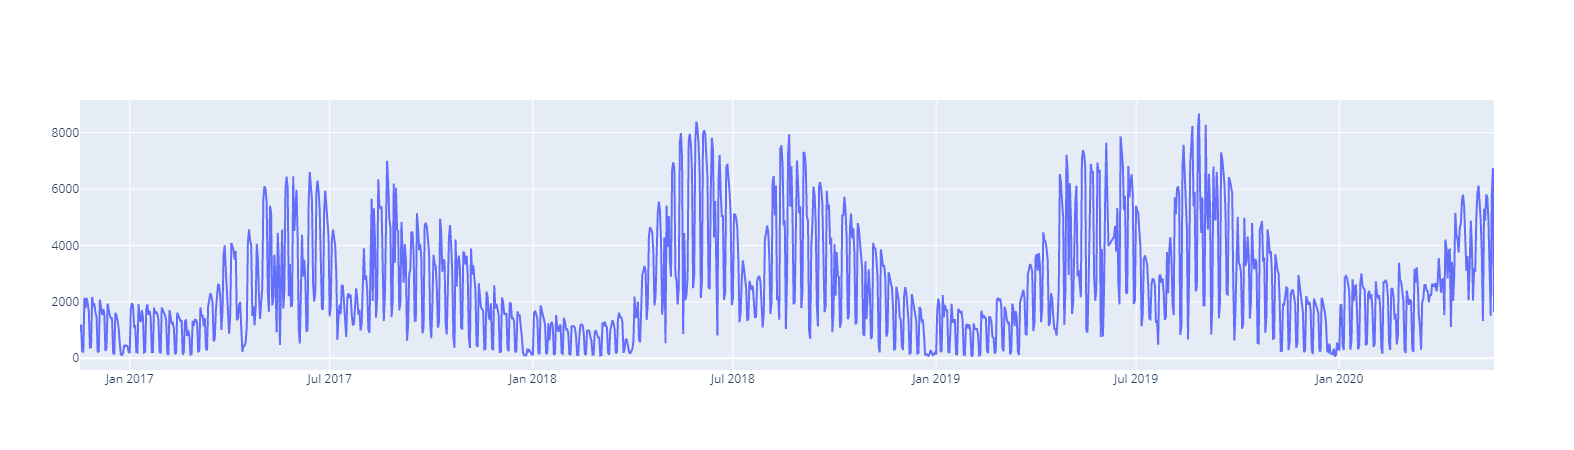

In [113]:
fig = go.Figure()
#Create and style traces
fig.add_trace(go.Scatter(x=bikerides['ds'], y=bikerides['y'], name='Rides',))
fig.show()

## Removing weekend rides
We can see that the data has clear seasonality and maybe a slight positive trend although that is harder to see. We can also notice quite a lot of variability. Some of the variability is probably caused by weekends when people are not commuting to work. Let’s remove all the weekends from our data and see how it looks.

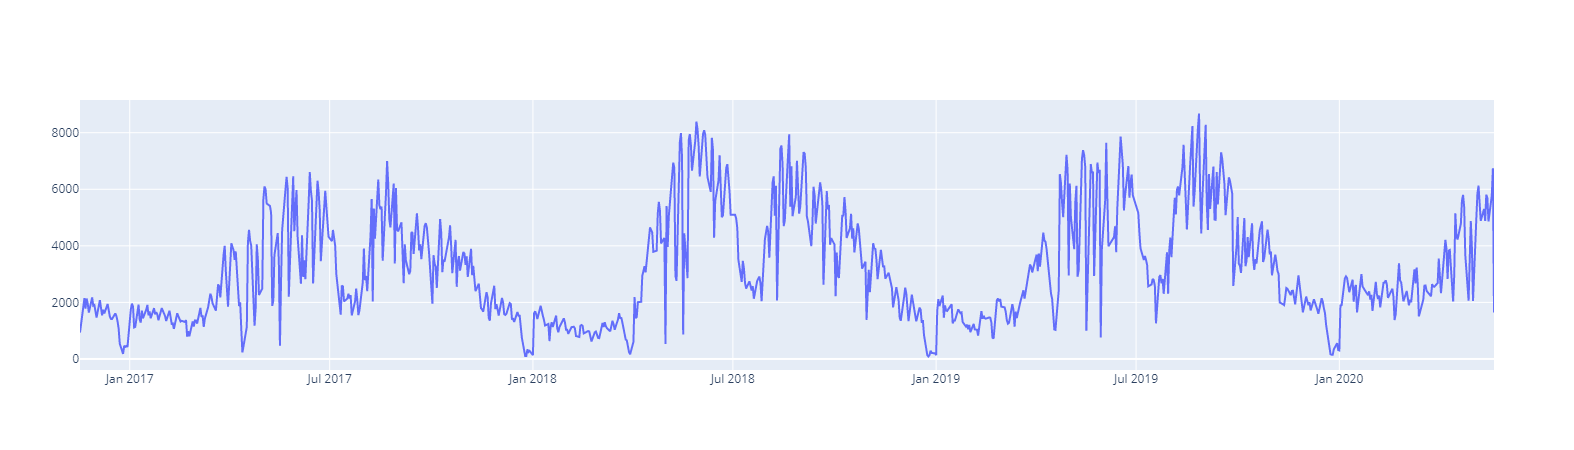

In [114]:
# Removing weekends
bikerides.set_index('ds', inplace=True)
bikerides = bikerides[bikerides.index.dayofweek < 5].reset_index()
#Plot
fig = go.Figure()
#Create and style traces
fig.add_trace(go.Scatter(x=bikerides['ds'], y=bikerides['y'], name='Rides',))
fig.show()

Still some variability but considerable less. Hopefully much of the remaining variability can be explained by seasonality, holidays and our additional weather regressors: rain and temperature. We’ll see shortly.

## Applying Box Cox transformation
For time-series it’s often useful to do some form of power transform of the data to stabilise variance and make the data more normal distribution-like. But what transformation to use for the best result? Fortunately, we can use a Box Cox transformation that evaluates a set of lambda coefficients (λ) and selects the value that achieves the best approximation of normality. We can do it like so:

In [115]:
# Apply Box-Cox Transform and save the lambda for later inverse.
bikerides['y'], lam = boxcox(bikerides['y'])
print('Lambda is:', lam)

Lambda is: 0.45166936452584744


In [116]:
bikerides.head()

ds          y  rain  temp
0 2016-11-17  46.380133   9.0   2.1
1 2016-11-18  52.168620   6.7   3.9
2 2016-11-21  68.606195   7.3   2.8
3 2016-11-22  62.876067   0.8   4.5
4 2016-11-23  68.427220   4.8   6.5

In [163]:
bikerides[['ds','y']].to_csv('dataset_b.csv')

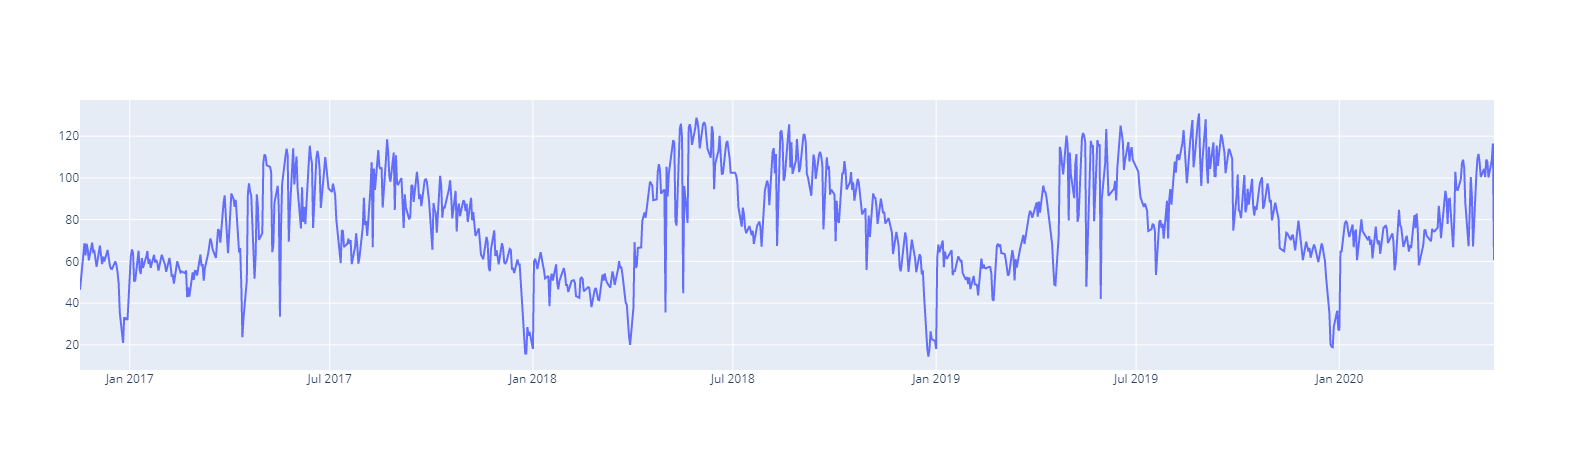

In [117]:
#Plot
fig = go.Figure()
#Create and style traces
fig.add_trace(go.Scatter(x=bikerides['ds'], y=bikerides['y'], name='Rides',))
fig.show()

We can se that the variance is less now, especially around the seasonal peaks.

## Plotting the weather data
When we’re into plotting let’s have a look at the rain and temperature data as well. Before we plot we normalise the data so we get comparable scales.

In [118]:
bikerides.head()

ds          y  rain  temp
0 2016-11-17  46.380133   9.0   2.1
1 2016-11-18  52.168620   6.7   3.9
2 2016-11-21  68.606195   7.3   2.8
3 2016-11-22  62.876067   0.8   4.5
4 2016-11-23  68.427220   4.8   6.5

In [119]:
# normalize data
scaler = preprocessing.MinMaxScaler()
bikerides_source = bikerides.set_index('ds')
bikerides_norm = scaler.fit_transform(bikerides_source)
bikerides_norm = pd.DataFrame(bikerides_norm,columns=bikerides_source.columns, index=bikerides_source.index)
bikerides_norm.reset_index(inplace=True)
bikerides_norm.head()

ds         y      rain      temp
0 2016-11-17  0.274449  0.227848  0.361930
1 2016-11-18  0.324168  0.169620  0.410188
2 2016-11-21  0.465355  0.184810  0.380697
3 2016-11-22  0.416137  0.020253  0.426273
4 2016-11-23  0.463818  0.121519  0.479893

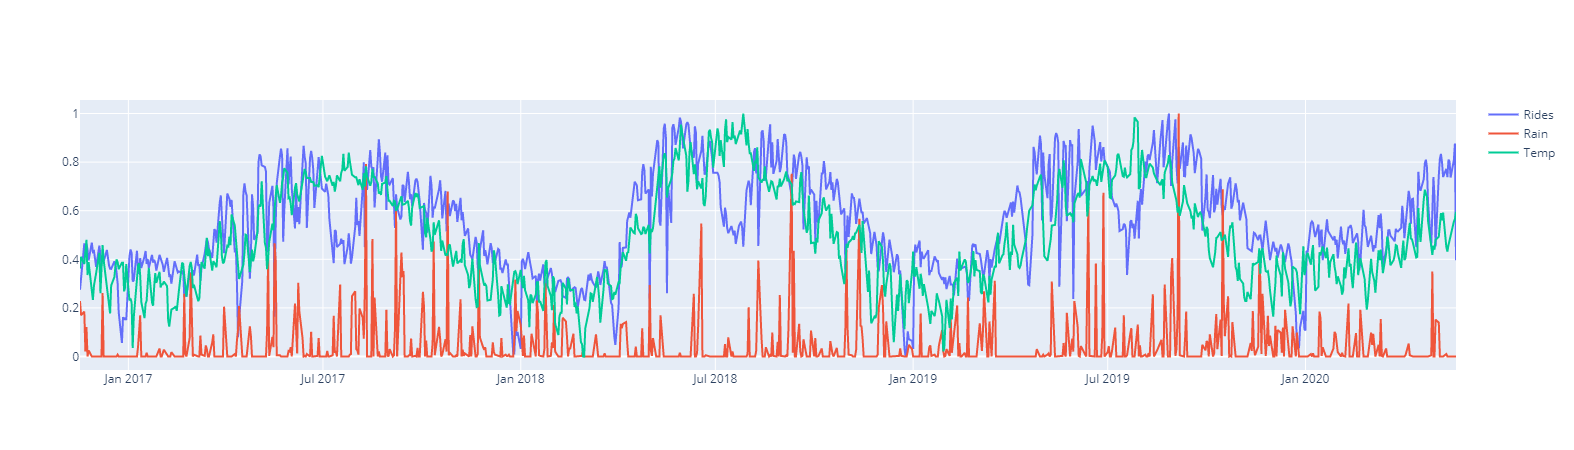

In [120]:
#Plot
fig = go.Figure()
#Create and style traces
fig.add_trace(go.Scatter(x=bikerides_norm['ds'], y=bikerides_norm['y'], name='Rides',))
fig.add_trace(go.Scatter(x=bikerides_norm['ds'], y=bikerides_norm['rain'], name='Rain',))
fig.add_trace(go.Scatter(x=bikerides_norm['ds'], y=bikerides_norm['temp'], name='Temp',))
fig.show()

Not surprisingly, the temperature is highly correlated to the commute volume. We see a break in the pattern in July most likely due to the Norwegian common holiday. When it comes to the rain it’s harder to draw any conclusions from the plot but when zooming in there are signs that rain might play a role. We’ll see.

Ok, it looks like we are ready to go. Let’s do some forecasting.

## Forecasting with prophet — a baseline

The Prophet code flow is really simple: First get hold of a Prophet instance and fit a model with our bike rides data frame. Then we create a data frame holding the prediction dates (horizon) and pass that into the Prophet predict method, like so:

In [128]:
# Hyperparameters
PERIODS = 180
FREQ = 'D'

# Forecasting
m = Prophet()
 
# Fit the data. Remember that prophet expect "ds" and "y" as names for the columns.
m.fit(bikerides)
 
# We must create a data frame holding dates for our forecast. The periods # parameter counts days as long as the frequency is 'D' for the day. Let's # do a 180 day forecast, approximately half a year.
future = m.make_future_dataframe(periods=PERIODS, freq=FREQ)
# Create the forecast object which will hold all of the resulting data from the forecast.
forecast = m.predict(future)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [129]:
# List the predicted values with a lower and upper band
display(bikerides.tail())
display(forecast.tail())

ds           y  rain  temp
904 2020-05-14  107.810568   0.0   6.5
905 2020-05-15  100.190723   0.0   7.4
906 2020-05-18  108.488423   0.0   9.3
907 2020-05-19  116.498600   0.0   9.7
908 2020-05-20   60.600695   0.0  10.8

ds      trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
1084 2020-11-12  85.577167   64.004357   95.208535    85.415936    85.744176   
1085 2020-11-13  85.589843   58.160519   88.845404    85.427815    85.759369   
1086 2020-11-14  85.602520   45.123556   77.663615    85.439857    85.773746   
1087 2020-11-15  85.615197   45.364809   76.030123    85.451283    85.788512   
1088 2020-11-16  85.627874   65.337251   96.531612    85.462709    85.802607   

      additive_terms  additive_terms_lower  additive_terms_upper     weekly  \
1084       -6.348334             -6.348334             -6.348334   3.843964   
1085      -11.845046            -11.845046            -11.845046  -0.717733   
1086      -24.676501            -24.676501            -24.676501 -12.765006   
1087      -25.303754            -25.303754            -25.303754 -12.765006   
1088       -5.182079             -5.182079             -5.182079   7.825216   

      weekly_lower  weekly_upper     yearly  yearly_lower  yearly_upper  \
1084      3.843964      3.843964 -10.192298    -10.192298    -10.192298   
1085     -0.717733     -0.717733 -11.127313    -11.127313    -11.127313   
1086    -12.765006    -12.765006 -11.911495    -11.911495    -11.911495   
1087    -12.765006    -12.765006 -12.538747    -12.538747    -12.538747   
1088      7.825216      7.825216 -13.007295    -13.007295    -13.007295   

      multiplicative_terms  multiplicative_terms_lower  \
1084                   0.0                         0.0   
1085                   0.0                         0.0   
1086                   0.0                         0.0   
1087                   0.0                         0.0   
1088                   0.0                         0.0   

      multiplicative_terms_upper       yhat  
1084                         0.0  79.228832  
1085                         0.0  73.744797  
1086                         0.0  60.926019  
1087                         0.0  60.311443  
1088                         0.0  80.445795

<ipython-input-130-d3965b29b9e5>:3: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.

<ipython-input-130-d3965b29b9e5>:5: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



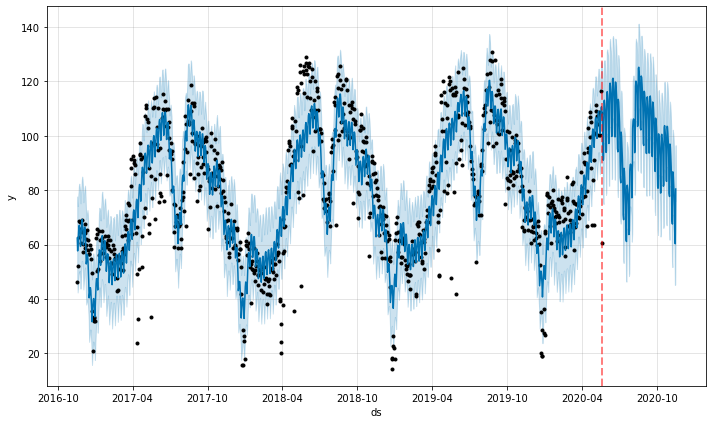

In [130]:
# Plotting with Prophet built-in method
fig = m.plot(forecast)
ax = fig.add_subplot(111)
ax.axvline(x=forecast['ds'].max() - pd.Timedelta('180 days'), c='red', lw=2, alpha=0.5, ls='--')
fig.show()

You can also add change-points (where the trend model is shifting) to the plot like this:

<ipython-input-69-1f7e4c26d9df>:3: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.

<ipython-input-69-1f7e4c26d9df>:5: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



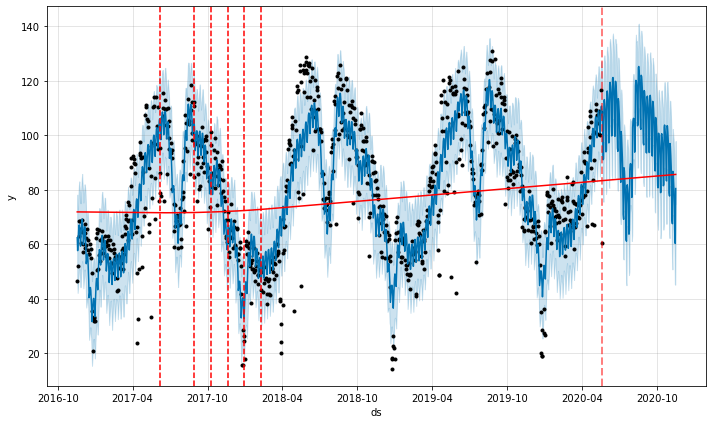

In [69]:
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)
ax = fig.add_subplot(111)
ax.axvline(x=forecast['ds'].max() - pd.Timedelta('180 days'), c='red', lw=2, alpha=0.5, ls='--')
fig.show()

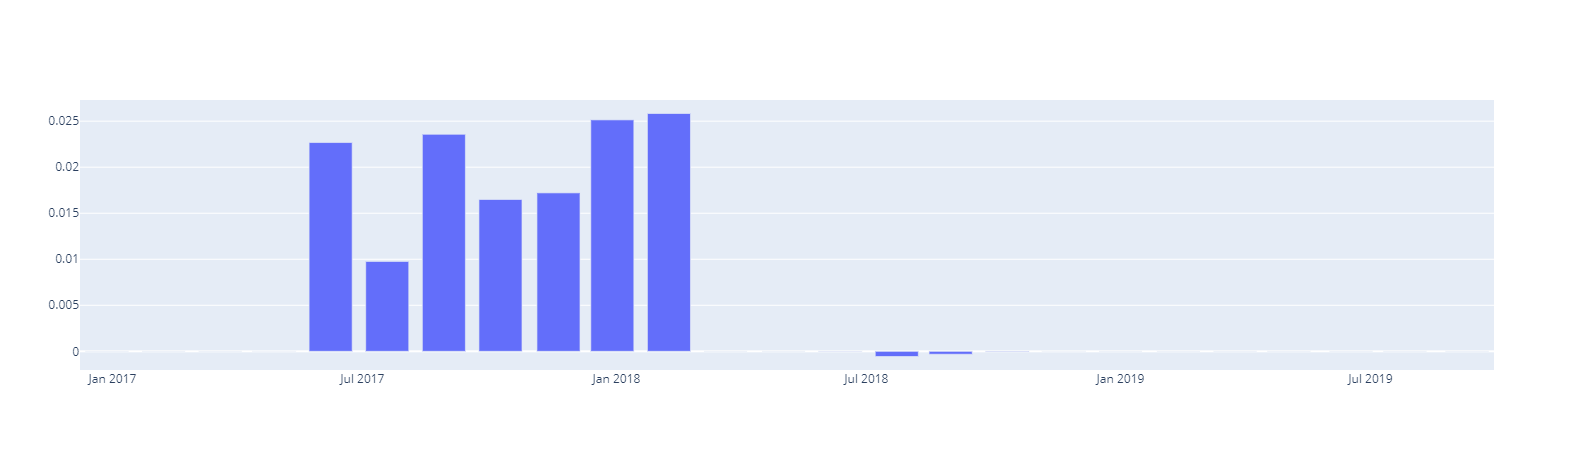

In [133]:
# Listing all the change points in the model
deltas = m.params['delta'].mean(0)
cp = pd.DataFrame(m.changepoints)
cp['deltas'] = deltas
fig = go.Figure()
# Create and style traces
fig.add_trace(go.Bar(x=cp['ds'], y=cp['deltas'], name='CPs',))

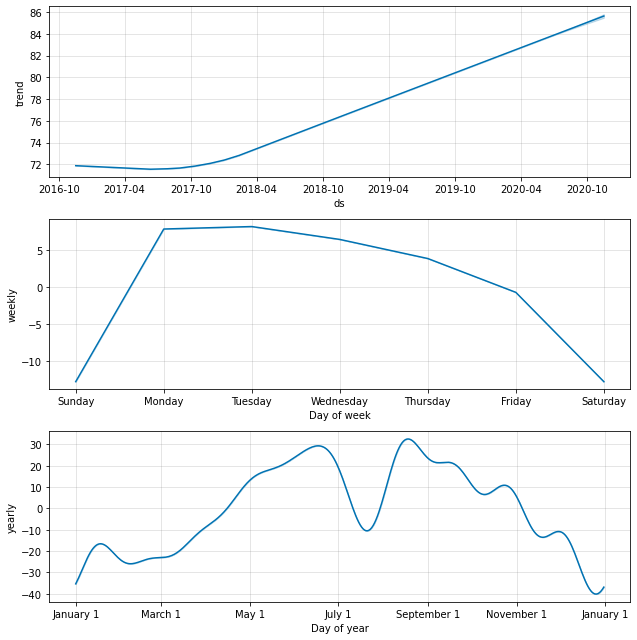

In [134]:
fig = m.plot_components(forecast)

## Validating our results

### Cross validation
In order for us to find out how our model performs and know if we are making progress we need some form of validation. We could, of course, write our own validation code, but fortunately we don’t have to, because Prophet provides most of what we need.

The Prophet library makes it possible to divide our historical data into training data and testing data for cross validation. The main concepts for cross validation with Prophet are:

Training data (initial): The amount of data set aside for training. The parameter is in the API called initial.
Horizon: The data set aside for validation. If you don’t define a period the model will be fitted with Horizon/2.
Cutoff (period): a forecast is made for every observed point between cutoff and cutoff + horizon.
The resulting data frame can now be used to compute error measures of yhat vs. y. Below I’ve plotted a chart with some markers to help you understand in a more visual way. In this example, we have a one year horizon and the model will make predictions for each month (~31 days).

INFO:fbprophet:Making 6 forecasts with cutoffs between 2018-12-17 00:00:00 and 2019-05-21 00:00:00


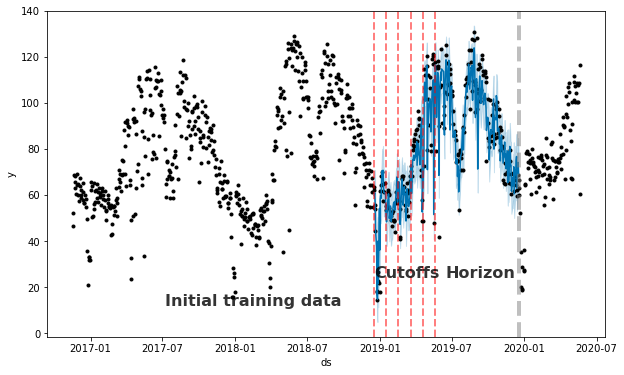

In [109]:
# Fit the model with two years of data and define a horizon of 365 days forcasting per month
df_cv = cross_validation(m, initial='730 days', period = '31 days', horizon = '365 days')

cutoffs = df_cv.groupby('cutoff').mean().reset_index()['cutoff']
cutoff = df_cv['cutoff'].unique()[0]
df_cv = df_cv[df_cv['cutoff'].values == cutoff]

fig = plt.figure(facecolor='w', figsize=(10, 6))
ax = fig.add_subplot(111)
ax.plot(m.history['ds'].values, m.history['y'], 'k.')
ax.plot(df_cv['ds'].values, df_cv['yhat'], ls='-', c='#0072B2')
ax.fill_between(df_cv['ds'].values, df_cv['yhat_lower'],
                df_cv['yhat_upper'], color='#0072B2',
                alpha=0.2)
#ax.axvline(x=pd.to_datetime(cutoff), c='gray', lw=4, alpha=0.5)
ax.set_ylabel('y')
ax.set_xlabel('ds')

# Making all the vlines for cutoffs
for item in cutoffs:
  ax.axvline(x=pd.to_datetime(item), c='red', lw=2, alpha=0.5, ls='--')

# Adding text to describe the data set splits
ax.text(x=pd.to_datetime('2017-07-07'),y=12, s='Initial training data', color='black',
       fontsize=16, fontweight='bold', alpha=0.8)
ax.text(x=pd.to_datetime('2018-12-17'),y=24, s='Cutoffs', color='black',
       fontsize=16, fontweight='bold', alpha=0.8)

ax.text(x=pd.to_datetime(cutoff) + pd.Timedelta('180 days'),y=24, s='Horizon', color='black',
       fontsize=16, fontweight='bold', alpha=0.8)

ax.axvline(x=pd.to_datetime(cutoff) + pd.Timedelta('365 days'), c='gray', lw=4,
           alpha=0.5, ls='--')

## Getting the performance metrics
So we have now made our first forecast with the Prophet library. But how do we know if the results are any good? Fortunately, Prophet comes with some built-in performance metrics that can help us out. I’m not going into the details when it comes to which metrics to use and leave that up to you. The performance metrics available are:

Mse: mean absolute error
Rmse: mean squared error
Mae: Mean average error
Mape: Mean average percentage error
Mdape: Median average percentage error
The code for validating and gathering performance metrics is shown below. First you need to get the cross validation data (we already did that in the above code listing, it’s the data frame called cv_df )Then we put the cross validation data frame into the Prophet method perfomance_metrics, like so:

In [108]:
df_cv.head()

ds       yhat  yhat_lower  yhat_upper          y     cutoff
0 2018-12-18  59.856134   49.874576   69.988833  62.128455 2018-12-17
1 2018-12-19  60.955923   51.336858   70.282686  53.800971 2018-12-17
2 2018-12-20  57.067909   46.608110   67.210968  55.606656 2018-12-17
3 2018-12-21  44.752911   34.401241   54.685002  44.352882 2018-12-17
4 2018-12-24  37.497859   27.303179   47.592769  18.080842 2018-12-17

In [102]:
df_p = performance_metrics(df_cv)
df_p.head(5)

horizon        mse      rmse       mae      mape     mdape  coverage
0 36 days  96.369051  9.816774  6.624858  0.228518  0.084014       0.8
1 37 days  96.168700  9.806564  6.549695  0.227316  0.084014       0.8
2 38 days  94.376325  9.714748  6.364564  0.223666  0.078180       0.8
3 39 days  95.112286  9.752553  6.487372  0.225947  0.083313       0.8
4 42 days  95.786012  9.787033  6.636311  0.228814  0.083313       0.8

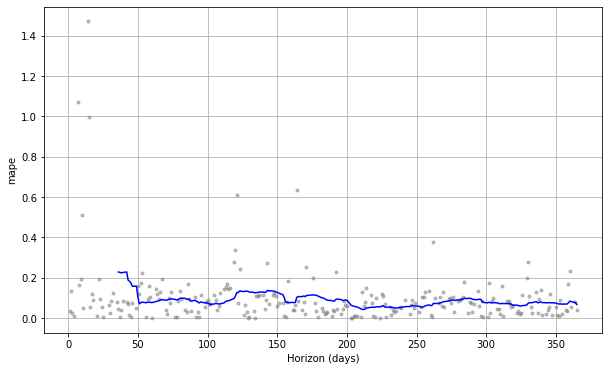

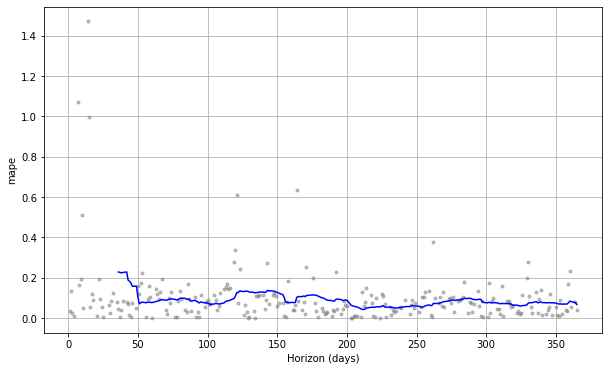

In [103]:
plot_cross_validation_metric(df_cv, metric='mape')

In [135]:
df_p.mean()

horizon     199 days 23:35:10.344827586
mse                             81.5664
rmse                            8.61502
mae                             6.76368
mape                          0.0883184
mdape                         0.0712083
coverage                       0.804483
dtype: object

In [136]:
def getPerformanceMetrics(m):
  return performance_metrics(getCrossValidationData(m))

def getCrossValidationData(m):
 return cross_validation(m, initial='730 days', period = '31 days', horizon = '365 days')

In [137]:
m = Prophet()
m.add_country_holidays(country_name='NO')
m.fit(bikerides)
# List the holiday names
m.train_holiday_names

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


0                    Søndag
1           Første påskedag
2           Arbeidernes dag
3           Første pinsedag
4            Første juledag
5         Første nyttårsdag
6              Grunnlovsdag
7             Andre juledag
8              Skjærtorsdag
9                Langfredag
10           Andre påskedag
11    Kristi himmelfartsdag
12           Andre pinsedag
dtype: object

In [141]:
# Hyperparameters
PERIODS = 180
FREQ = 'D'

# Forecasting
m = Prophet()

# add holiday
m.add_country_holidays(country_name='NO')
 
# Fit the data. Remember that prophet expect "ds" and "y" as names for the columns.
m.fit(bikerides)
 
# We must create a data frame holding dates for our forecast. The periods # parameter counts days as long as the frequency is 'D' for the day. Let's # do a 180 day forecast, approximately half a year.
future = m.make_future_dataframe(periods=PERIODS, freq=FREQ)
# Create the forecast object which will hold all of the resulting data from the forecast.
forecast = m.predict(future)


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [142]:
# List the predicted values with a lower and upper band
display(bikerides.tail())
display(forecast.tail())

ds           y  rain  temp
904 2020-05-14  107.810568   0.0   6.5
905 2020-05-15  100.190723   0.0   7.4
906 2020-05-18  108.488423   0.0   9.3
907 2020-05-19  116.498600   0.0   9.7
908 2020-05-20   60.600695   0.0  10.8

ds      trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
1084 2020-11-12  85.735911   67.671457   92.589216    85.468933    85.968976   
1085 2020-11-13  85.746902   60.971831   86.978142    85.476539    85.982300   
1086 2020-11-14  85.757894   47.099950   73.684126    85.485194    85.994537   
1087 2020-11-15  85.768886   45.856088   72.132801    85.494005    86.006589   
1088 2020-11-16  85.779877   66.824999   94.353500    85.502931    86.020053   

      Andre juledag  Andre juledag_lower  Andre juledag_upper  Andre pinsedag  \
1084            0.0                  0.0                  0.0             0.0   
1085            0.0                  0.0                  0.0             0.0   
1086            0.0                  0.0                  0.0             0.0   
1087            0.0                  0.0                  0.0             0.0   
1088            0.0                  0.0                  0.0             0.0   

      ...     weekly  weekly_lower  weekly_upper     yearly  yearly_lower  \
1084  ...   4.698954      4.698954      4.698954 -10.632712    -10.632712   
1085  ...  -0.643528     -0.643528     -0.643528 -11.495122    -11.495122   
1086  ... -13.316391    -13.316391    -13.316391 -12.234067    -12.234067   
1087  ... -13.316391    -13.316391    -13.316391 -12.845898    -12.845898   
1088  ...   8.478088      8.478088      8.478088 -13.330421    -13.330421   

      yearly_upper  multiplicative_terms  multiplicative_terms_lower  \
1084    -10.632712                   0.0                         0.0   
1085    -11.495122                   0.0                         0.0   
1086    -12.234067                   0.0                         0.0   
1087    -12.845898                   0.0                         0.0   
1088    -13.330421                   0.0                         0.0   

      multiplicative_terms_upper       yhat  
1084                         0.0  79.802153  
1085                         0.0  73.608253  
1086                         0.0  60.207436  
1087                         0.0  59.606596  
1088                         0.0  80.927544  

[5 rows x 61 columns]

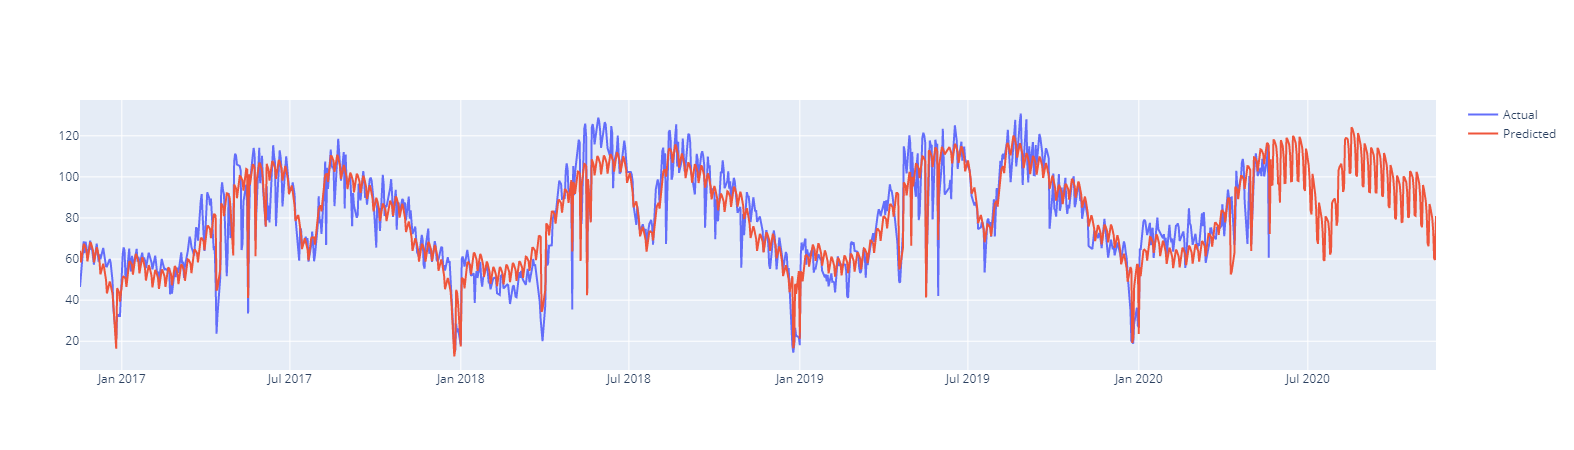

In [143]:
fig = go.Figure()
# Create and style traces
fig.add_trace(go.Scatter(x=bikerides['ds'], y=bikerides['y'], name='Actual',))
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat'], name='Predicted',))
# fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['holidays'], name='Holidays',))
fig.show()

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


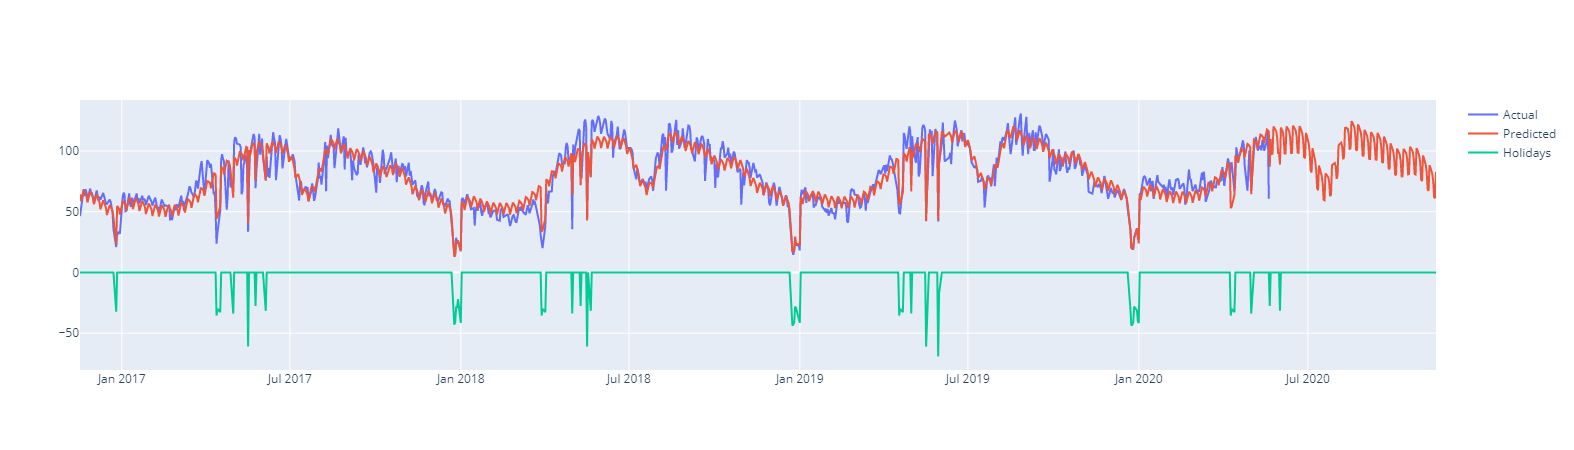

In [150]:
ascensionday = pd.DataFrame({
  'holiday': 'AscensionDay',
  'ds': pd.to_datetime(['2019-05-30']),
  'lower_window': 0,
  'upper_window': 1,
})

christmas = pd.DataFrame({
  'holiday': 'Christmas',
  'ds': pd.to_datetime(['2017-12-24','2018-12-24','2019-12-24','2020-12-24']),
  'lower_window': -1,
  'upper_window': 7,
})

holidays = pd.concat((ascensionday, christmas))

m = Prophet(holidays=holidays)
m.add_country_holidays(country_name='NO')
m.fit(bikerides)
future = m.make_future_dataframe(periods=180, freq='D')
forecast = m.predict(future)

fig = go.Figure()
# Create and style traces
fig.add_trace(go.Scatter(x=bikerides['ds'], y=bikerides['y'], name='Actual',))
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat'], name='Predicted',))
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['holidays'], name='Holidays',))
fig.show()

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


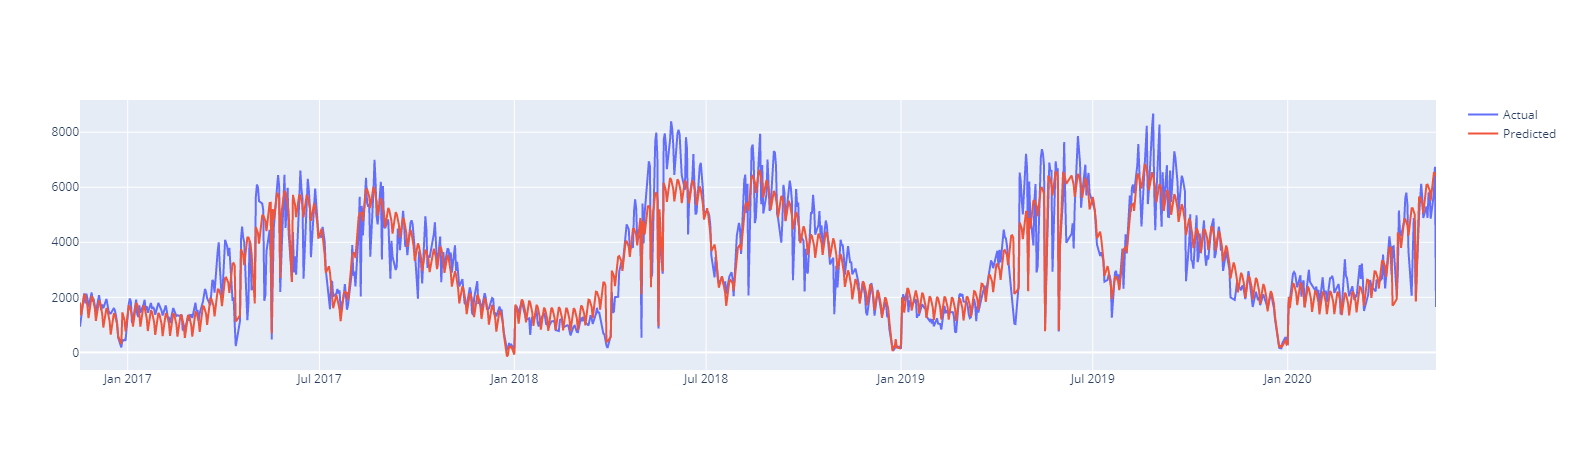

In [160]:
m = Prophet(holidays=holidays)
m.add_country_holidays(country_name='NO')
# Adding the extra weather regressors
# m.add_regressor('rain')
# m.add_regressor('temp')

m.fit(bikerides)
future = m.make_future_dataframe(periods=0, freq='D')
future = future.merge(bikerides, on='ds')
forecast = m.predict(future)
fig = go.Figure()

# Create and style traces
fig.add_trace(go.Scatter(x=bikerides['ds'], y=bikerides['y'], name='Actual',))
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat'], name='Predicted',))
# fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['rain'], name='Rain',))
# fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['temp'], name='Temp',))
fig.show()

In [161]:
getPerformanceMetrics(m).mean()

INFO:fbprophet:Making 6 forecasts with cutoffs between 2018-12-17 00:00:00 and 2019-05-21 00:00:00


horizon     201 days 00:00:00
mse                    989130
rmse                  984.728
mae                   765.115
mape                  0.29998
mdape                0.196216
coverage             0.730056
dtype: object

In [93]:
def create_param_combinations(**param_dict):
    param_iter = itertools.product(*param_dict.values())
    params =[]
    for param in param_iter:
        params.append(param) 
    params_df = pd.DataFrame(params, columns=list(param_dict.keys()))
    return params_df

def single_cv_run(history_df, metrics, param_dict, parallel):
    m = Prophet(holidays=holidays, **param_dict)
    m.add_country_holidays(country_name='NO')
    # Adding the extra weather regressors
    m.add_regressor('rain')
    m.add_regressor('temp')
    m.fit(history_df)
    df_cv = getCrossValidationData(m)
    df_p = performance_metrics(df_cv, rolling_window=1)
    df_p['params'] = str(param_dict)
    df_p = df_p.loc[:, metrics]
    return df_p

#'changepoint_range': [0.6, 0.7, 0.75, 0.8, 0.9],
#'changepoint_prior_scale': [0.01, 0.05, 0.1, 0.25, 0.5],
#'seasonality_prior_scale':[0.5, 1.0, 2.5, 5],
#'holidays_prior_scale':[1.0, 5.0, 10.0, 15.0],
#'yearly_seasonality':[5, 10, 15, 20],
#'weekly_seasonality':[5, 10, 15, 20],
pd.set_option('display.max_colwidth', None)
param_grid = {                  
                'changepoint_prior_scale': [0.01],
                'changepoint_range': [0.3],
                'holidays_prior_scale':[1.0],
                'seasonality_prior_scale':[0.5],
                'yearly_seasonality':[20],
                'weekly_seasonality':[5],
              }
metrics = ['horizon', 'rmse', 'mae', 'mape', 'mdape','params'] 
results = []

#Prophet(,)
params_df = create_param_combinations(**param_grid)
for param in params_df.values:
    param_dict = dict(zip(params_df.keys(), param))
    cv_df = single_cv_run(bikerides,  metrics, param_dict, parallel="processes")
    results.append(cv_df)
results_df = pd.concat(results).reset_index(drop=True)
best_param = results_df.loc[results_df['rmse'] == min(results_df['rmse']), ['params']]
print(f'\n The best param combination is {best_param.values[0][0]}')
results_df.mean()

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 6 forecasts with cutoffs between 2018-12-17 00:00:00 and 2019-05-21 00:00:00




 The best param combination is {'changepoint_prior_scale': 0.01, 'changepoint_range': 0.3, 'holidays_prior_scale': 1.0, 'seasonality_prior_scale': 0.5, 'yearly_seasonality': 20.0, 'weekly_seasonality': 5.0}


horizon    365 days 00:00:00
rmse                 9.38234
mae                  6.94737
mape               0.0923588
mdape              0.0692171
dtype: object

In [94]:
m = Prophet(holidays=holidays, changepoint_prior_scale=0.01,
            changepoint_range=0.8,
            seasonality_prior_scale=0.5,
            holidays_prior_scale=1.0,
            yearly_seasonality=20,
            weekly_seasonality=5,
            seasonality_mode='additive')

m.add_country_holidays(country_name='NO')
# Adding the extra weather regressors
m.add_regressor('rain')
m.add_regressor('temp')
    
m.fit(bikerides)
getPerfomanceMetrics(m).mean()

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 6 forecasts with cutoffs between 2018-12-17 00:00:00 and 2019-05-21 00:00:00


horizon     201 days 00:00:00
mse                   85.4072
rmse                  9.21225
mae                   6.88381
mape                0.0890592
mdape               0.0677684
coverage              0.78372
dtype: object

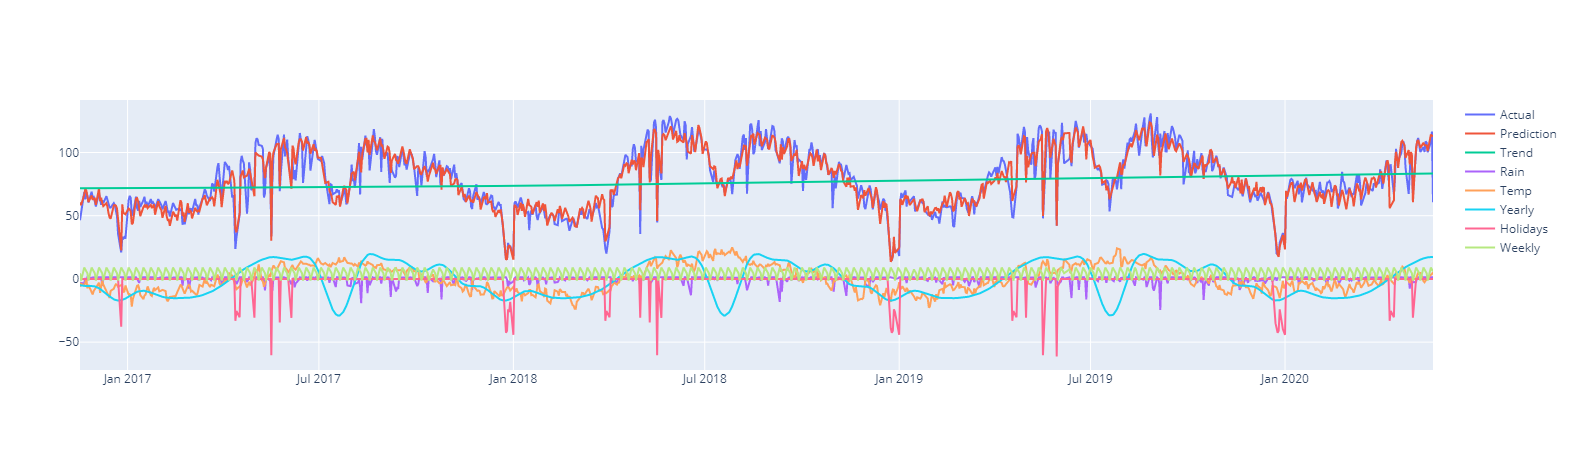

In [95]:
fig = go.Figure()
# Create and style traces
fig.add_trace(go.Scatter(x=bikerides['ds'], y=bikerides['y'], name='Actual',))
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat'], name='Prediction',))
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['trend'], name='Trend',))
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['rain'], name='Rain',))
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['temp'], name='Temp',))
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yearly'], name='Yearly',))
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['holidays'], name='Holidays',))
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['weekly'], name='Weekly',))
fig.show()

In [96]:
# Let's get the sum of yhat (the prediction)
sum_yhat = forecast['yhat'].sum()
print('Forecast sum is:', sum_yhat)

sum_components = forecast['trend'].sum()+forecast['yearly'].sum()+ forecast['weekly'].sum()+forecast['holidays'].sum()+ forecast['extra_regressors_additive'].sum()
print('Sum of components is:', sum_components)
print('The model is equal to the sum of its components:', sum_yhat.round()==sum_components.round())

Forecast sum is: 71674.68429384785
Sum of components is: 71674.68429384787
The model is equal to the sum of its components: True


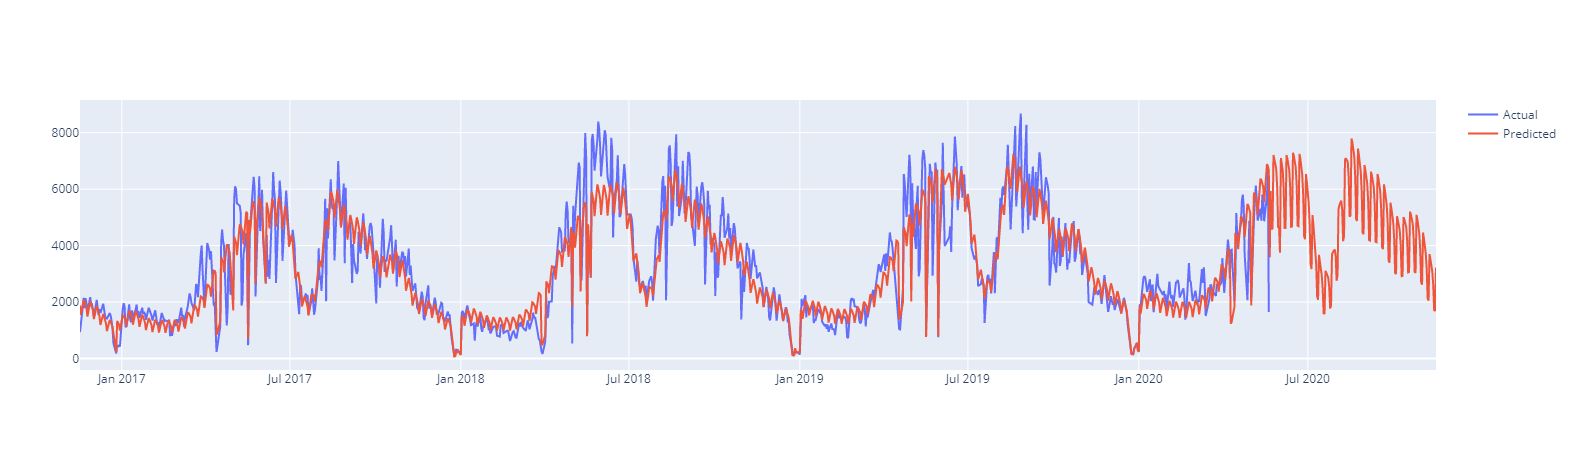

In [157]:

# Transform back to reality from Box Cox
forecast[['yhat','yhat_upper','yhat_lower']] = forecast[['yhat','yhat_upper','yhat_lower']].apply(lambda x: inv_boxcox(x, lam))
bikerides['y'] = inv_boxcox(bikerides['y'], lam)

# Plot the results
fig = go.Figure()
fig.add_trace(go.Scatter(x=bikerides['ds'], y=bikerides['y'], name='Actual',))
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat'], name='Predicted',))
fig.show()